In [13]:
import subprocess
import sys

required_libraries = [
    'random',
    're',
    'json', 
    'textblob',
    'gensim',
    'nltk',
    'matplotlib',
    'datetime', 
]
def install_package(package_name):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

def install_required_packages(libraries):
    for library in libraries:
        try:
            __import__(library)
        except ImportError:
            print(f"Installing {library}...")
            install_package(library)

install_required_packages(required_libraries)

import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cleme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from random import randint
from re import sub
from json import loads, dump
from textblob import TextBlob
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from typing import List
from heapq import nlargest
from matplotlib.pyplot import figure, bar, xlabel, ylabel, title, show
from matplotlib.pyplot import barh, gca, subplots, subplots_adjust
from matplotlib.ticker import MaxNLocator
from datetime import datetime

In [5]:
def process_json_file(storage_file="zone d’atterrissage.json", file_to_read="aitweets2.json"):
    user_list = [f"user{x}" for x in range(100)]

    with open(storage_file, "w", encoding='utf-8'):
        pass

    lines = read_file(file_to_read)

    with open(storage_file, "a", encoding="utf-8") as json_file:
        for line_num, line in enumerate(lines):
            Tweet = loads(line)

            if not checking_structure(Tweet):
                continue
            
            Tweet.setdefault("Author", user_list[randint(0, len(user_list) - 1)])
            
            for key in Tweet:
                Tweet[key] = tweet_analyze(Tweet[key])

            dump(Tweet, json_file, ensure_ascii=False)
            if line_num < len(lines) - 1:
                json_file.write('\n')


def checking_structure(tweet):
    expected_keys = {"id", "AuthorLocation", "CreatedAt", "RetweetCount", "TweetLanguage", "TweetText"}
    return expected_keys.issubset(tweet.keys())
    

def read_file(file_name="zone d’atterrissage.json"):
    with open(file_name, "r", encoding="utf-8") as file:      
        return file.readlines()
    
def tweet_analyze(tweet_txt):
    if isinstance(tweet_txt, str):
        return sub(r"[^A-Za-z0-9\s@#(){}[\]<>«»&\-_+*/%'°:€£$&.,;!?]", '', tweet_txt)
    return tweet_txt

In [6]:
def feelings_text(tweet_txt):
    blob = TextBlob(tweet_txt)
    feelings = blob.sentiment.polarity
    if feelings > 0:
        return "Positive"
    elif feelings < 0:
        return "Negative"
    else:
        return "Neutral"
    
def extraction_target_character(tweet_txt, target_character):
    stockage = {}
    words = tweet_txt.split()
    for word in words:
        if target_character in word:
            stockage[word] = stockage.get(word, 0) + 1  
    return stockage

def autor_finder(tweet_dict):
    return tweet_dict.get("Author")


def tweet_topics_finder(tweet_txt: str, num_topics: int = 5) -> List[str]:
    # Ensure the tweet is not empty
    if not tweet_txt.strip():
        return []

    # Set up stop words
    stop_words = set(stopwords.words('english'))
    
    # Tokenize the tweet and filter words
    words = word_tokenize(tweet_txt)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.isalpha() and len(word) > 1]

    # If there are no valid words after filtering, return an empty list
    if not filtered_words:
        return []

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary([filtered_words])
    corpus = [dictionary.doc2bow(filtered_words)]
    
    # Train the LDA model
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

    # Get topics and their probabilities
    topics = lda_model[corpus[0]]

    # Find the dominant topic
    dominant_topic = max(topics, key=lambda x: x[1])[0]

    # Retrieve the top words for the dominant topic
    top_words = sorted(lda_model.show_topic(dominant_topic), key=lambda x: x[1], reverse=True)

    # Extract the top words as the tweet topic
    tweet_topic = [word for word, _ in top_words[:num_topics]]

    return tweet_topic


In [7]:
class TweetObjectCreator:
    def extract_caracter(self, caracter):
        return extraction_target_character(self.TweetText, caracter)

    def Feelings(self):
        return feelings_text(self.TweetText)

    def Topics_(self):
        return tweet_topics_finder(self.TweetText)

    def __init__(self, tweet_zone_atterissage):
        self.Author = tweet_zone_atterissage.get("Author", "")
        self.id = tweet_zone_atterissage.get("id", "")
        self.AuthorLocation = tweet_zone_atterissage.get("AuthorLocation", "")
        self.CreatedAt = tweet_zone_atterissage.get("CreatedAt", "")
        self.RetweetCount = tweet_zone_atterissage.get("RetweetCount", "")
        self.TweetLanguage = tweet_zone_atterissage.get("TweetLanguage", "")
        self.TweetText = tweet_zone_atterissage.get("TweetText", "")
        self.HashtagDict = self.extract_caracter("#")
        self.MentionnedUser = self.extract_caracter("@")
        self.Sentiment = self.Feelings()
        self.Topics = self.Topics_()

def transformation_object(file_lines):
    tweet_list = []
    for line in file_lines:
        tweet_list.append(TweetObjectCreator(loads(line)))
    return tweet_list

In [8]:
def aggregate_dict(tweetlist, key_extractor, ReTweet):
    result_dict = {}  # Use a normal dictionary
    for tweet in tweetlist:
        for key, count in key_extractor(tweet).items():
            if key in result_dict:
                result_dict[key] += count
            else:
                result_dict[key] = count
            # Add Retweet count if specified
            if ReTweet:
                result_dict[key] += int(tweet.RetweetCount)
    return result_dict

def hashtag_dict(tweetlist, ReTweet):
    return aggregate_dict(tweetlist, lambda tweet: tweet.HashtagDict, ReTweet)

def user_dict(tweetlist, ReTweet):
    return aggregate_dict(tweetlist, lambda tweet: {tweet.Author: 1}, ReTweet)

def mentioned_dict(tweetlist, ReTweet):
    return aggregate_dict(tweetlist, lambda tweet: tweet.MentionnedUser, ReTweet)

def topic_dict(tweetlist, ReTweet):
    return aggregate_dict(tweetlist, lambda tweet: {topic: 1 for topic in tweet.Topics}, ReTweet)

def top_k(tweetlist, k, search_type="hashtag", ReTweet=True):
    if search_type == "hashtag":
        dict_k = hashtag_dict(tweetlist, ReTweet)
    elif search_type == "user":
        dict_k = user_dict(tweetlist, ReTweet)
    elif search_type == "mentioned":
        dict_k = mentioned_dict(tweetlist, ReTweet)
    elif search_type == "topic":
        dict_k = topic_dict(tweetlist, ReTweet)
    else:
        raise ValueError("Invalid search_type. Use 'hashtag', 'user', 'mentioned', or 'topic'.")
    
    return dict(nlargest(k, dict_k.items(), key=lambda item: item[1]))

def get_tweets(tweet_list, user, search_type='user'):
    if search_type == "user":
        return {tweet.TweetText: tweet.CreatedAt[:10] for tweet in tweet_list if tweet.Author == user}
    elif search_type == "mention":
        return {tweet.TweetText: tweet.CreatedAt[:10] for tweet in tweet_list if user in tweet.MentionnedUser}
    else:
        raise ValueError("Invalid search_type. Use 'user' or 'mention'.")
    

def get_users(tweet_list, term, search_type="hashtag"):
    result = {}
    if search_type == "hashtag":
        for tweet in tweet_list:
            if term in tweet.HashtagDict:
                if tweet.Author in result:
                    result[tweet.Author] += 1
                else:
                    result[tweet.Author] = 1
    elif search_type == "mention":
        for tweet in tweet_list:
            if term == tweet.Author:
                for mentioned_user in tweet.MentionnedUser:
                    if mentioned_user in result:
                        result[mentioned_user] += 1
                    else:
                        result[mentioned_user] = 1
    else:
        raise ValueError("Invalid search_type. Use 'hashtag' or 'mention'.")
    
    return result

In [9]:
def visualyze_stick_digram(data, axis_x, axis_y, tile_name, size_fig=(8, 8), vertical=True):
    categories = list(data.keys())
    values = list(data.values())

    figure(figsize=size_fig)
    
    xlabel(axis_x)
    ylabel(axis_y)
    title(tile_name)

    if vertical:
        bar(categories, values)
        gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        barh(categories, values)
        gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    show()

def visualize_timeline(data, axis_x, axis_y, title_name, size_fig=(15, 15)):
    tweets_texts = list(data.keys())
    tweets_dates = list(data.values())

    tweets_texts = [text.replace('\n', '') for text in tweets_texts]

    tweets_dates = [datetime.strptime(date, '%Y-%m-%d') for date in tweets_dates]

    tweet_count = {}
    for date in tweets_dates:
        date_str = date.strftime('%Y-%m-%d')
        if date_str in tweet_count:
            tweet_count[date_str] += 1
        else:
            tweet_count[date_str] = 1

    fig, (ax1, ax2) = subplots(1, 2, figsize=size_fig)
    subplots_adjust(wspace=-0.45)
    y_positions = {}
    for date, _ in zip(tweets_dates, tweets_texts):
        date_str = date.strftime('%Y-%m-%d')
        count = tweet_count[date_str]
        if date_str in y_positions:
            y_pos = y_positions[date_str]
        else:
            y_pos = 0
            y_positions[date_str] = y_pos

        ax1.plot_date(date, count - y_pos, markersize=10)
        y_positions[date_str] += 1

    ax1.xaxis_date()
    fig.autofmt_xdate()

    for i, (text, date) in enumerate(zip(tweets_texts, tweets_dates)):
        ax2.text(0.502, 0.95 - i * 0.05, text, va='top', ha='left')
        ax2.plot(0.5, 0.95 - i * 0.05, marker='o', markersize=8)

    ax2.axis("off")
    ax1.set_xlabel(axis_x)
    ax1.set_ylabel('Number of Tweets')
    ax1.set_title(title_name)
    ax1.set_ylim(0, max(tweet_count.values()) + 1)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.grid()

    show()


In [10]:
process_json_file(storage_file="zone d’atterrissage.json", file_to_read="aitweets2.json")
line = read_file(file_name="zone d’atterrissage.json")
object_list = transformation_object(line)

In [21]:
top_hashtag= top_k(object_list, 10, search_type='hashtag', ReTweet=False)
top_user = top_k(object_list, 10, search_type='user')
top_mentionned = top_k(object_list, 10, search_type='mentioned')
top_topic = top_k(object_list, 10, search_type='topic')
number_user = user_dict(object_list, ReTweet=False)
number_hashtag = hashtag_dict(object_list, ReTweet=False)
number_topic = topic_dict(object_list, ReTweet=False)
user_hashtag = get_users(object_list, "#IA", search_type="hashtag")
user_mention = get_users(object_list, "user46", search_type="mention")

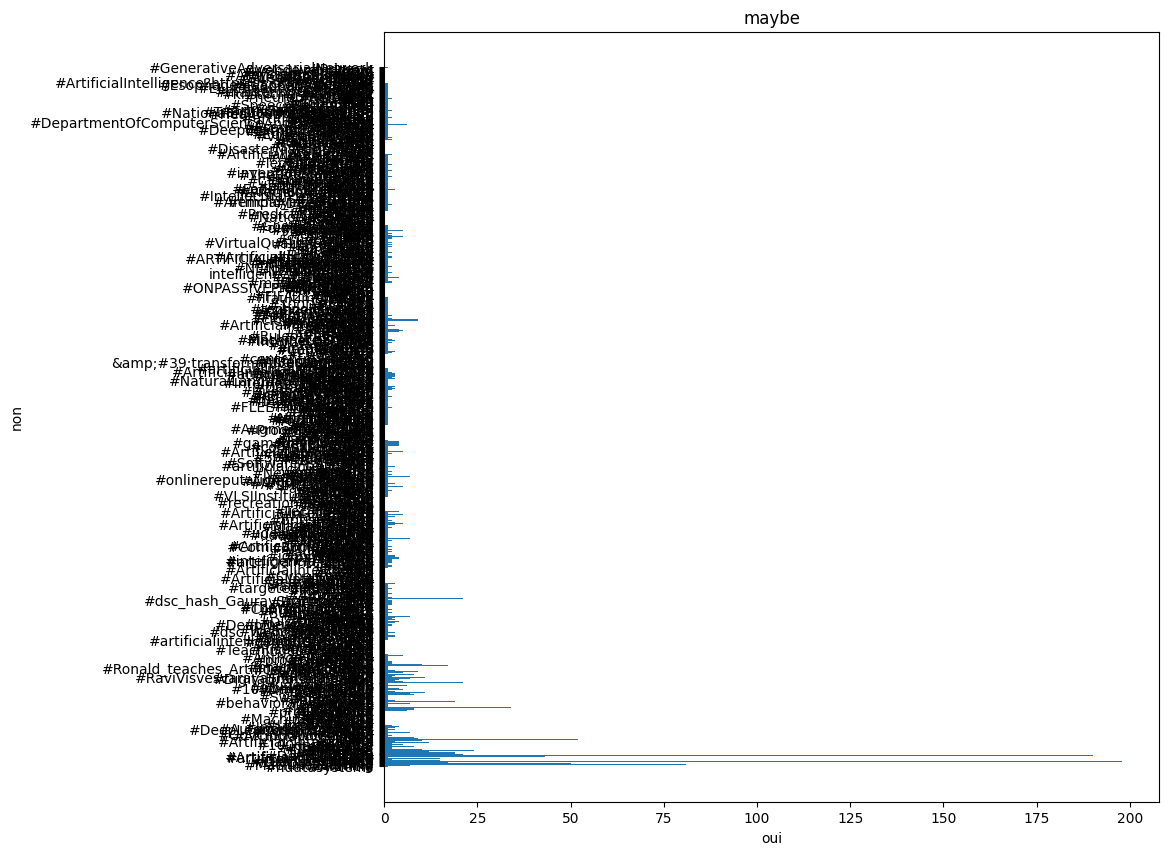

In [22]:
visualyze_stick_digram(number_hashtag, "oui", "non", "maybe", size_fig=(10, 10), vertical=False)

In [23]:
tweet_mention = get_tweets(object_list, "@Datascience__", search_type="mention")
tweet_user = get_tweets(object_list, "user42", search_type="user")

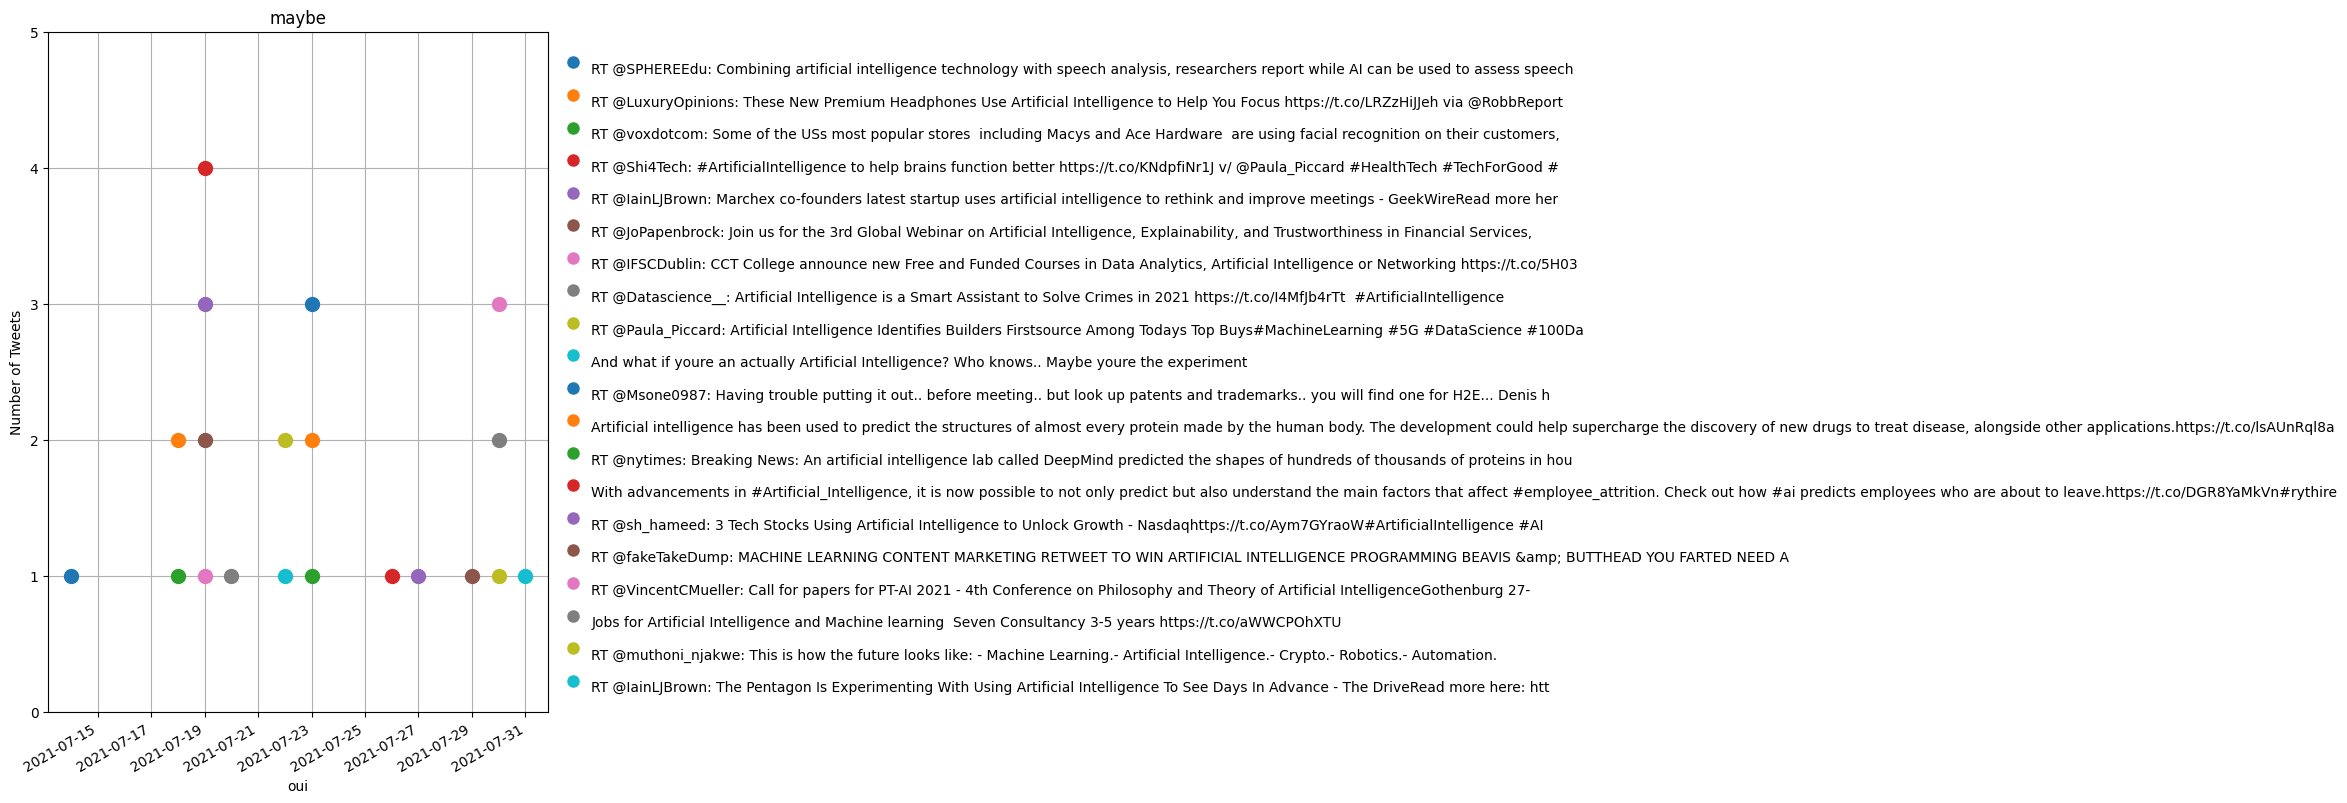

In [24]:
visualize_timeline(tweet_user, "oui", "non", "maybe", (10, 10))